In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
joebeachcapital_fantasy_football_path = kagglehub.dataset_download('joebeachcapital/fantasy-football')

print('Data source import complete.')


Using Colab cache for faster access to the 'fantasy-football' dataset.
Data source import complete.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead

In [4]:
df = pd.read_csv('cleaned_merged_seasons.csv')
df.head()

/tmp/ipython-input-2940553115.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_merged_seasons.csv')


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1


In [5]:
#CHANGE ALL GKP TO GK FOR CONSISTENCY

df["position"] = df["position"].str.strip().str.upper()
df.loc[df["position"] == "GKP", "position"] = "GK"


In [6]:
df['position'].value_counts()

,count
position,
MID,39163
DEF,33683
FWD,12669
GK,10654


In [7]:
from decimal import Decimal, ROUND_HALF_UP

In [8]:
#FIXING THE ICT_INDEX FOR PLAYERS WHO HAVE IT MISCALCULATED

for col in ["influence", "creativity", "threat", "ict_index"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Compute the corrected ICT index
df["ict_test"] = (
    (df["influence"] + df["creativity"] + df["threat"]) / 10
).apply(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"), rounding=ROUND_HALF_UP)))



In [9]:
# Compare with existing ICT index
df["ict_boolean"] = (df["ict_test"].round(1) == df["ict_index"].round(1))

In [10]:
#counting how many inconsistency was found before
false_before = df["ict_boolean"].value_counts().get(False, 0)
print(f"Incorrect ICT index values before replacement: {false_before}")

Incorrect ICT index values before replacement: 1450


In [11]:
# Replace incorrect ICT index values with correct ones
df.loc[~df["ict_boolean"], "ict_index"] = df.loc[~df["ict_boolean"], "ict_test"]
df["ict_boolean"] = (df["ict_test"].round(1) == df["ict_index"].round(1))

false_after = df["ict_boolean"].value_counts().get(False, 0)
print(f"Incorrect ICT index values after replacement: {false_after}")

Incorrect ICT index values after replacement: 0


In [12]:
df = df.sort_values(by=["season_x", "element", "name", "GW"]).reset_index(drop=True)

In [13]:
#FORMMMMM agdad haga bt handle kol haga yarab, bet handle b zero instead of average in case of missing GWs

def compute_form(player_df):
    """
    Compute form per row for a player in one season.

    Rules:
    - Look back up to the last 4 gameweeks (g-1, g-2, g-3, g-4)
    - Include all rows in those GWs (for DGWs)
    - If 4 or more consecutive GWs are missing → form = 0
    - Otherwise, take up to 4 most recent rows among those GWs,
      compute mean(total_points), then divide by 10.
    """
    # Ensure the internal DataFrame is sorted by GW before processing
    player_df = player_df.sort_values("GW").reset_index(drop=True)
    forms = []

    for i in range(len(player_df)):
        current_gw = int(player_df.loc[i, "GW"])

        # First match of season — form = 0
        if i == 0:
            forms.append(0.0)
            continue

        # Previous matches only. loc[:i-1] correctly includes earlier matches of the current GW (DGW).
        prev = player_df.loc[:i-1, ["GW", "total_points"]].copy()

        if prev.empty:
            forms.append(0.0)
            continue

        # Find the last distinct GW played by the player before the current row's GW.
        L_all = int(prev["GW"].max())

        if L_all == current_gw:
            # This is the 2nd (or later) match of a DGW/TGW. We need the GW before the current DGW.
            prev_gws = sorted(prev["GW"].unique(), reverse=True)
            if len(prev_gws) > 1:
                L = prev_gws[1] # The GW before the current DGW
            else:
                # Player's first match of season was a DGW M1
                L = L_all
        else:
            # The last match was in a GW before the current one.
            L = L_all

        k = current_gw - L - 1  # number of missing GWs before this one

        if k >= 4:
            forms.append(0.0)
            continue
        # ----------------------------------------

        # Target GWs: Look at the current GW (for DGW M1) and the 4 preceding GWs.
        # This guarantees g-1, g-2, g-3, g-4 are always included if played.
        # e.g., for GW 37, this is [37, 36, 35, 34, 33].
        target_gws = [current_gw - j for j in range(0, 5)]

        # Collect all rows from the previous matches that fall into those target GWs
        collected = prev[prev["GW"].isin(target_gws)].sort_values("GW", ascending=False)

        if collected.empty:
            forms.append(0.0)
            continue

        # If DGW/TGW causes >4 rows, keep only 4 most recent
        if len(collected) > 4:
            collected = collected.head(4)

        form_value = collected["total_points"].mean() / 10.0
        forms.append(form_value)

    player_df["form"] = forms
    return player_df

In [14]:
df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form)

df = df.sort_values(by=["season_x", "name", "GW"]).reset_index(drop=True)

print(df[["season_x", "element", "name", "GW", "total_points", "form"]].head(20))

   season_x  element             name  GW  total_points   form
0   2016-17      454  Aaron Cresswell   1             0  0.000
1   2016-17      454  Aaron Cresswell   2             0  0.000
2   2016-17      454  Aaron Cresswell   3             0  0.000
3   2016-17      454  Aaron Cresswell   4             0  0.000
4   2016-17      454  Aaron Cresswell   5             0  0.000
5   2016-17      454  Aaron Cresswell   6             0  0.000
6   2016-17      454  Aaron Cresswell   7             0  0.000
7   2016-17      454  Aaron Cresswell   8             6  0.000
8   2016-17      454  Aaron Cresswell   9             0  0.150
9   2016-17      454  Aaron Cresswell  10             1  0.150
10  2016-17      454  Aaron Cresswell  11             2  0.175
11  2016-17      454  Aaron Cresswell  12             1  0.225
12  2016-17      454  Aaron Cresswell  13             1  0.100
13  2016-17      454  Aaron Cresswell  14             0  0.125
14  2016-17      454  Aaron Cresswell  15             1

/tmp/ipython-input-2009105073.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form)


In [15]:
df = df.sort_values(by=["season_x", "element", "name", "GW"]).reset_index(drop=True)

In [16]:
#FORMMMMM agdad haga bt handle kol haga yarab, using Average
def compute_form(player_df):
    """
    Compute form per row for a player in one season.

    Rules:
    - Look back up to the last 4 gameweeks (g-1, g-2, g-3, g-4)
    - Include all rows in those GWs (for DGWs)
    - If 4 or more consecutive GWs are missing → form = 0
    - Otherwise, take up to 4 most recent rows among those GWs,
      compute mean(total_points), then divide by 10.
    """
    # Ensure the internal DataFrame is sorted by GW before processing
    player_df = player_df.sort_values("GW").reset_index(drop=True)
    forms = []

    season_avg = player_df["total_points"].mean() / 10.0 if not player_df.empty else 0.0

    for i in range(len(player_df)):
        current_gw = int(player_df.loc[i, "GW"])

        # First match of season — form = 0
        if i == 0:
            forms.append(0.0)
            continue

        # Previous matches only. loc[:i-1] correctly includes earlier matches of the current GW (DGW).
        prev = player_df.loc[:i-1, ["GW", "total_points"]].copy()

        if prev.empty:
            forms.append(0.0)
            continue

        # Find the last distinct GW played by the player before the current row's GW.
        L_all = int(prev["GW"].max())

        if L_all == current_gw:
            # This is the 2nd (or later) match of a DGW/TGW. We need the GW before the current DGW.
            prev_gws = sorted(prev["GW"].unique(), reverse=True)
            if len(prev_gws) > 1:
                L = prev_gws[1] # The GW before the current DGW
            else:
                # Player's first match of season was a DGW M1
                L = L_all
        else:
            # The last match was in a GW before the current one.
            L = L_all

        k = current_gw - L - 1  # number of missing GWs before this one

        if k >= 4:
            forms.append(season_avg)
            continue
        # ----------------------------------------

        # Target GWs: Look at the current GW (for DGW M1) and the 4 preceding GWs.
        # This guarantees g-1, g-2, g-3, g-4 are always included if played.
        # e.g., for GW 37, this is [37, 36, 35, 34, 33].
        target_gws = [current_gw - j for j in range(0, 5)]

        # Collect all rows from the previous matches that fall into those target GWs
        collected = prev[prev["GW"].isin(target_gws)].sort_values("GW", ascending=False)

        if collected.empty:
            forms.append(0.0)
            continue

        # If DGW/TGW causes >4 rows, keep only 4 most recent
        if len(collected) > 4:
            collected = collected.head(4)

        form_value = collected["total_points"].mean() / 10.0
        forms.append(form_value)

    player_df["form_avg"] = forms
    return player_df

In [17]:
df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form)

df = df.sort_values(by=["season_x", "name", "GW"]).reset_index(drop=True)

print(df[["season_x", "element", "name", "GW", "total_points", "form_avg"]].head(20))

   season_x  element             name  GW  total_points  form_avg
0   2016-17      454  Aaron Cresswell   1             0     0.000
1   2016-17      454  Aaron Cresswell   2             0     0.000
2   2016-17      454  Aaron Cresswell   3             0     0.000
3   2016-17      454  Aaron Cresswell   4             0     0.000
4   2016-17      454  Aaron Cresswell   5             0     0.000
5   2016-17      454  Aaron Cresswell   6             0     0.000
6   2016-17      454  Aaron Cresswell   7             0     0.000
7   2016-17      454  Aaron Cresswell   8             6     0.000
8   2016-17      454  Aaron Cresswell   9             0     0.150
9   2016-17      454  Aaron Cresswell  10             1     0.150
10  2016-17      454  Aaron Cresswell  11             2     0.175
11  2016-17      454  Aaron Cresswell  12             1     0.225
12  2016-17      454  Aaron Cresswell  13             1     0.100
13  2016-17      454  Aaron Cresswell  14             0     0.125
14  2016-1

/tmp/ipython-input-2953797464.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form)


In [18]:
#FILLING IN TEAM_X FOR MISSING VALUES
def normalize_text_col(s):
    # keep NaN as NaN, otherwise strip and map empty-like tokens to NaN
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if s == "" or s.lower() in {"nan", "none", "na"}:
        return np.nan
    return s


In [19]:
# Apply normalization to the columns we depend on
for col in ["team_x", "opp_team_name", "fixture", "season_x"]:
    if col in df.columns:
        df[col] = df[col].apply(normalize_text_col)

In [20]:
# Quick diagnostics before
total_rows = len(df)
missing_before = df["team_x"].isna().sum()
print(f"Total rows: {total_rows}")
print(f"Missing team_x BEFORE: {missing_before}")

Total rows: 96169
Missing team_x BEFORE: 19852


In [21]:
# 2) Build lookup of groups by (season_x, fixture)
# Only include groups where fixture is not null (can't infer without fixture)
grouped = {}
for (season, fixture), g in df.groupby(["season_x", "fixture"]):
    grouped[(season, fixture)] = g

# 3) Fill only missing rows and collect diagnostics
filled_count = 0
filled_examples = []
not_filled_examples = []

In [22]:
def infer_team_for_row(row, grouped):
    # row is a Series
    fixture = row["fixture"]
    season = row["season_x"]
    opponent = row.get("opp_team_name", None)

    if pd.isna(fixture) or pd.isna(season):
        return np.nan, "no_fixture_or_season"

    grp = grouped.get((season, fixture))
    if grp is None or grp.empty:
        return np.nan, "no_group_found"

    # 1) Direct mapping: find rows in same fixture whose opp_team_name == this row's opp_team_name
    #    and which have team_x present; those rows' team_x are candidates for this player's team_x.
    if opponent is not None:
        candidates = grp.loc[(grp["opp_team_name"] == opponent) & grp["team_x"].notna(), "team_x"].unique()
        if len(candidates) > 0:
            return candidates[0], "direct_candidate"

    # 2) Fallback by elimination: if exactly two distinct opp_team_name values present,
    #    pick the one that is NOT this row's opponent.
    distinct_opps = grp["opp_team_name"].dropna().unique().tolist()
    if len(distinct_opps) == 2 and opponent is not None:
        other = [t for t in distinct_opps if t != opponent]
        if len(other) == 1:
            return other[0], "inferred_by_elimination"

    # 3) If group has team_x values for some rows, but none directly match, try other heuristics:
    #    - If there is exactly one unique non-null team_x in group, assume both rows belong to single team (rare).
    teamx_vals = grp["team_x"].dropna().unique().tolist()
    if len(teamx_vals) == 1:
        return teamx_vals[0], "single_teamx_in_group"

    # 4) Nothing good — return NaN
    return np.nan, "could_not_infer"

In [23]:
# Apply only on rows where team_x is missing
mask_missing = df["team_x"].isna()
rows_to_process = df[mask_missing].copy()

# We'll store the inferred results in a column and a reason
inferred = []
reasons = []
for idx, r in rows_to_process.iterrows():
    val, reason = infer_team_for_row(r, grouped)
    inferred.append(val)
    reasons.append(reason)
# Put back into the dataframe (only for the missing rows)
df.loc[mask_missing, "team_x_filled_candidate"] = inferred
df.loc[mask_missing, "team_x_fill_reason"] = reasons


In [24]:
# Merge only where missing
before_missing = df["team_x"].isna().sum()
df["team_x"] = df["team_x"].fillna(df["team_x_filled_candidate"])
after_missing = df["team_x"].isna().sum()
filled_count = before_missing - after_missing

In [25]:
# Collect small samples for debugging
filled_examples = df.loc[df["team_x_fill_reason"].notna() & df["team_x"].notna(),
                         ["season_x","fixture","name","opp_team_name","team_x","team_x_fill_reason"]].head(10)
not_filled_examples = df.loc[df["team_x"].isna(), ["season_x","fixture","name","opp_team_name"]].head(10)

In [26]:
print(f"Filled this run: {filled_count}")
print("Sample filled rows (up to 10):")
print(filled_examples.to_string(index=False))

print(f"Remaining missing team_x AFTER: {after_missing}")
print("Sample not-filled rows (up to 10):")
print(not_filled_examples.to_string(index=False))

Filled this run: 19852
Sample filled rows (up to 10):
season_x fixture            name  opp_team_name   team_x      team_x_fill_reason
 2016-17      10 Aaron Cresswell        Chelsea West Ham inferred_by_elimination
 2016-17      20 Aaron Cresswell    Bournemouth West Ham inferred_by_elimination
 2016-17      29 Aaron Cresswell       Man City West Ham inferred_by_elimination
 2016-17      38 Aaron Cresswell        Watford West Ham inferred_by_elimination
 2016-17      46 Aaron Cresswell      West Brom West Ham inferred_by_elimination
 2016-17      59 Aaron Cresswell    Southampton West Ham inferred_by_elimination
 2016-17      70 Aaron Cresswell  Middlesbrough West Ham inferred_by_elimination
 2016-17      74 Aaron Cresswell Crystal Palace West Ham inferred_by_elimination
 2016-17      90 Aaron Cresswell     Sunderland West Ham inferred_by_elimination
 2016-17      92 Aaron Cresswell        Everton West Ham inferred_by_elimination
Remaining missing team_x AFTER: 0
Sample not-filled row

In [27]:
# Cleanup helper columns
df.drop(columns=["team_x_filled_candidate","team_x_fill_reason"], errors='ignore', inplace=True)

In [28]:
def add_upcoming_points(df):
    # Sort globally
    df = df.sort_values(by=['season_x', 'element', 'GW', 'kickoff_time']).reset_index(drop=True)

    # Prepare the output column
    df['upcoming_total_points'] = np.nan

    def compute_group(g):
        g = g.sort_values(['GW', 'kickoff_time']).copy()
        n = len(g)
        upcoming = np.full(n, np.nan)
        avg_points = g['total_points'].mean()
        full_season = len(g) == 38

        for i in range(n):
            current_gw = g.iloc[i]['GW']

            # If it's the last game, no upcoming GW
            if i == n - 1 or current_gw == 38:
                upcoming[i] = 0
                continue

            next_gw = g.iloc[i + 1]['GW']

            # Case 1: Double GW (same GW)
            if next_gw == current_gw:
                upcoming[i] = g.iloc[i + 1]['total_points']
                continue

            # Case 2: Consecutive GW (GW + 1)
            if next_gw == current_gw + 1:
                upcoming[i] = g.iloc[i + 1]['total_points']
                continue

            # Case 3: Non-consecutive GW (gap)
            if full_season:
                # For full season → find next valid GW below
                next_rows = g.iloc[i + 1:][g.iloc[i + 1:]['GW'] > current_gw]
                if not next_rows.empty:
                    upcoming[i] = next_rows.iloc[0]['total_points']
                else:
                    upcoming[i] = round(avg_points)
            else:
                # For partial season, directly use average when GW gap found
                upcoming[i] = round(avg_points)

        g['upcoming_total_points'] = upcoming.astype(int)
        return g

    # Apply to each (season, element)
    df = df.groupby(['season_x', 'element'], group_keys=False).apply(compute_group)

    df['upcoming_total_points'] = df['upcoming_total_points'].astype(int)
    return df

In [29]:
df = add_upcoming_points(df)


/tmp/ipython-input-640594494.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['season_x', 'element'], group_keys=False).apply(compute_group)


In [30]:
# TAGHEER EL POSITIONS EL GHALAT
# Show all rows if needed
pd.set_option('display.max_rows', None)

In [31]:
# -------------------------------
# Define FPL rules
# -------------------------------

In [32]:
def expected_points_def(row):
    pts = 0
    if 0 < row['minutes'] < 60:
        pts += 1
    elif row['minutes'] >= 60:
        pts += 2
    pts += (
        6 * row['goals_scored'] +
        3 * row['assists'] +
        4 * row['clean_sheets'] * (row['minutes'] >= 60) +
        (-1) * np.floor(row['goals_conceded'] / 2) +
        (-2) * row['penalties_missed'] +
        (-2) * row['own_goals'] +
        (-3) * row['red_cards'] +
        (-1) * row['yellow_cards'] +
        row['bonus']
    )
    return pts

In [33]:
def expected_points_mid(row):
    pts = 0
    if 0 < row['minutes'] < 60:
        pts += 1
    elif row['minutes'] >= 60:
        pts += 2
    pts += (
        5 * row['goals_scored'] +
        3 * row['assists'] +
        1 * row['clean_sheets'] * (row['minutes'] >= 60) +
        (-2) * row['penalties_missed'] +
        (-2) * row['own_goals'] +
        (-3) * row['red_cards'] +
        (-1) * row['yellow_cards'] +
        row['bonus']
    )
    return pts

In [34]:
def expected_points_fwd(row):
    pts = 0
    if 0 < row['minutes'] < 60:
        pts += 1
    elif row['minutes'] >= 60:
        pts += 2
    pts += (
        4 * row['goals_scored'] +
        3 * row['assists'] +
        (-2) * row['penalties_missed'] +
        (-2) * row['own_goals'] +
        (-3) * row['red_cards'] +
        (-1) * row['yellow_cards'] +
        row['bonus']
    )
    return pts

In [35]:
def calc_expected_points(row):
    if row['position'] == 'DEF':
        return expected_points_def(row)
    elif row['position'] == 'MID':
        return expected_points_mid(row)
    elif row['position'] == 'FWD':
        return expected_points_fwd(row)
    else:
        return 0

In [36]:
# -------------------------------
# Correction logic
# -------------------------------

def fix_positions(df):
    df_outfield = df[df['position'].isin(['DEF', 'MID', 'FWD'])].copy()
    iteration = 0

    while True:
        iteration += 1
        df_outfield['expected_points'] = df_outfield.apply(calc_expected_points, axis=1)
        df_outfield['difference'] = df_outfield['total_points'] - df_outfield['expected_points']

        inconsistencies = df_outfield[df_outfield['difference'] != 0].copy()
        print(f"\nIteration {iteration}: {len(inconsistencies)} inconsistencies found")

        if len(inconsistencies) == 0:
            break

        for idx, row in inconsistencies.iterrows():
            if pd.isnull(row['total_points']):
                continue

            def_pts = expected_points_def(row)
            mid_pts = expected_points_mid(row)
            fwd_pts = expected_points_fwd(row)

            diffs = {
                'DEF': abs(row['total_points'] - def_pts),
                'MID': abs(row['total_points'] - mid_pts),
                'FWD': abs(row['total_points'] - fwd_pts)
            }

            best_pos = min(diffs, key=diffs.get)

            if best_pos != row['position'] and diffs[best_pos] == 0:
                print(f"→ Changing {row['name']} ({row['season_x']}) from {row['position']} to {best_pos}")
                df_outfield.loc[idx, 'position'] = best_pos
                df_outfield.loc[
                    (df_outfield['name'] == row['name']) &
                    (df_outfield['season_x'] == row['season_x']),
                    'position'
                ] = best_pos

    # Re-calculate expected_points and difference one last time after all position changes
    df_outfield['expected_points'] = df_outfield.apply(calc_expected_points, axis=1)
    df_outfield['difference'] = df_outfield['total_points'] - df_outfield['expected_points']

    print("\nFinished position corrections.")
    return df_outfield # Return the modified dataframe

In [37]:
# Run position correction without overwriting original
df_test = fix_positions(df.copy())

print("\n=== Sample of corrected data ===")
print(df_test[['name', 'position', 'total_points', 'expected_points', 'difference']].head(20))


Iteration 1: 340 inconsistencies found
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to DEF
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to DEF
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to DEF
→ Changing Joshua King (2016-17) from FWD to DEF
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-17) from FWD to MID
→ Changing Joshua King (2016-

In [38]:
df.update(df_test)

In [39]:
# Adding new Features
df['minutes_form'] = df['minutes'] * df['form']
df["form_minutes_ratio"] = df["form"] / (df["minutes"] + 1)

df['minutes_form_avg'] = df['minutes'] * df['form_avg']
df["formAvg_minutes_ratio"] = df["form_avg"] / (df["minutes"] + 1)

df["is_home_int"] = df["was_home"].astype(int)
df["goal_contrib"] = df["goals_scored"] + df["assists"]
df["defensive_contrib"] = df["clean_sheets"] - df["goals_conceded"]
df["ict_per_minute"] = df["ict_index"] / (df["minutes"] + 1)
df['minutes_points'] = df['minutes'] * df['total_points']
df['minutes_ict'] = df['minutes'] * df['ict_index']

In [40]:
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead

In [41]:
df.describe()

,assists,bonus,bps,clean_sheets,creativity,element,goals_conceded,goals_scored,ict_index,influence,...,minutes_form,form_minutes_ratio,minutes_form_avg,formAvg_minutes_ratio,is_home_int,goal_contrib,defensive_contrib,ict_per_minute,minutes_points,minutes_ict
count,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,...,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000
mean,0.041042,0.108715,6.080275,0.106739,4.734000,327.063264,0.495887,0.045514,1.718850,7.146263,...,8.896402,0.023317,8.896402,0.023317,0.499787,0.086556,-0.389148,0.026304,110.796733,139.785893
std,0.215378,0.492334,9.850595,0.308783,10.689879,194.313766,0.974269,0.233644,3.042348,12.873136,...,15.665694,0.074800,15.665694,0.074800,0.500003,0.336472,1.072571,0.059294,220.646795,262.536744
min,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-18.000000,-0.300000,-18.000000,-0.300000,0.000000,0.000000,-9.000000,0.000000,-595.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001374,0.000000,0.001374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,10.000000,0.000000,2.400000,486.000000,1.000000,0.000000,2.500000,10.600000,...,13.500000,0.005556,13.500000,0.005556,1.000000,0.000000,0.000000,0.034066,160.000000,189.000000
max,4.000000,3.000000,128.000000,1.000000,170.900000,778.000000,9.000000,4.000000,32.800000,163.600000,...,180.000000,1.400000,180.000000,1.400000,1.000000,5.000000,1.000000,3.300000,2610.000000,2952.000000


In [42]:
problem_cases = []

# Get all unique (season, player) combinations
unique_pairs = df[['season_x', 'name']].drop_duplicates()

for _, pair in unique_pairs.iterrows():
    season = pair['season_x']
    player = pair['name']

    # Get all rows for this player in this season
    player_data = df[(df['season_x'] == season) & (df['name'] == player)]

    # Count how many matches (rows)
    num_rows = len(player_data)

    # Check if GW 38 exists for this player-season
    has_gw38 = 38 in player_data['GW'].values

    # If player has 38 matches but no GW 38 → add to list
    if num_rows == 38 and not has_gw38:
        problem_cases.append({
            'season_x': season,
            'name': player,
            'num_rows': num_rows,
            'has_gw38': has_gw38
        })

In [43]:
# Convert the list of dicts to a DataFrame
problem_cases_df = pd.DataFrame(problem_cases)

print(problem_cases_df)

Empty DataFrame
Columns: []
Index: []


In [44]:
pd.set_option('display.max_rows', None)
player_name = "Kevin De Bruyne"
season = "2017-18"

player_season_df = df[(df['name'] == player_name) & (df['season_x'] == season)]
player_season_df
# Pierre-Emerick Aubameyang
#Sergio Agüero
#Kevin De Bruyne

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,minutes_form,form_minutes_ratio,minutes_form_avg,formAvg_minutes_ratio,is_home_int,goal_contrib,defensive_contrib,ict_per_minute,minutes_points,minutes_ict
13659,2017-18,Kevin De Bruyne,MID,Man City,0,0,14,1,16.9,252,...,0.000000,0.000000,0.000000,0.000000,0,0,1,0.073626,270,603.0
13660,2017-18,Kevin De Bruyne,MID,Man City,0,0,16,0,54.4,252,...,27.000000,0.003297,27.000000,0.003297,1,0,-1,0.107692,180,882.0
13661,2017-18,Kevin De Bruyne,MID,Man City,0,1,24,0,69.3,252,...,22.500000,0.002747,22.500000,0.002747,0,0,-1,0.107692,270,882.0
13662,2017-18,Kevin De Bruyne,MID,Man City,2,0,38,1,66.6,252,...,24.000000,0.002930,24.000000,0.002930,1,2,1,0.141758,810,1161.0
13663,2017-18,Kevin De Bruyne,MID,Man City,1,0,31,1,65.0,252,...,27.625000,0.006439,27.625000,0.006439,0,1,1,0.192424,390,825.5
13664,2017-18,Kevin De Bruyne,MID,Man City,0,0,14,1,48.8,252,...,45.000000,0.005495,45.000000,0.005495,1,0,1,0.078022,270,639.0
13665,2017-18,Kevin De Bruyne,MID,Man City,0,3,32,1,87.3,252,...,47.250000,0.005769,47.250000,0.005769,0,1,1,0.171429,990,1404.0
13666,2017-18,Kevin De Bruyne,MID,Man City,2,1,39,0,35.1,252,...,47.125000,0.010985,47.125000,0.010985,1,2,-2,0.145455,585,624.0
13667,2017-18,Kevin De Bruyne,MID,Man City,1,0,26,1,50.2,252,...,57.275000,0.009062,57.275000,0.009062,1,1,1,0.150000,474,948.0
13668,2017-18,Kevin De Bruyne,MID,Man City,0,0,7,0,21.8,252,...,65.250000,0.007967,65.250000,0.007967,0,0,-2,0.057143,180,468.0


In [45]:
df['position'].value_counts()

,count
position,
MID,39617
DEF,33406
FWD,12492
GK,10654


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96169 entries, 0 to 96168
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season_x               96169 non-null  object 
 1   name                   96169 non-null  object 
 2   position               96169 non-null  object 
 3   team_x                 96169 non-null  object 
 4   assists                96169 non-null  int64  
 5   bonus                  96169 non-null  int64  
 6   bps                    96169 non-null  int64  
 7   clean_sheets           96169 non-null  int64  
 8   creativity             96169 non-null  float64
 9   element                96169 non-null  int64  
 10  fixture                96169 non-null  object 
 11  goals_conceded         96169 non-null  int64  
 12  goals_scored           96169 non-null  int64  
 13  ict_index              96169 non-null  float64
 14  influence              96169 non-null  float64
 15  kickoff

In [47]:
df.describe()

,assists,bonus,bps,clean_sheets,creativity,element,goals_conceded,goals_scored,ict_index,influence,...,minutes_form,form_minutes_ratio,minutes_form_avg,formAvg_minutes_ratio,is_home_int,goal_contrib,defensive_contrib,ict_per_minute,minutes_points,minutes_ict
count,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,...,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000
mean,0.041042,0.108715,6.080275,0.106739,4.734000,327.063264,0.495887,0.045514,1.718850,7.146263,...,8.896402,0.023317,8.896402,0.023317,0.499787,0.086556,-0.389148,0.026304,110.796733,139.785893
std,0.215378,0.492334,9.850595,0.308783,10.689879,194.313766,0.974269,0.233644,3.042348,12.873136,...,15.665694,0.074800,15.665694,0.074800,0.500003,0.336472,1.072571,0.059294,220.646795,262.536744
min,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-18.000000,-0.300000,-18.000000,-0.300000,0.000000,0.000000,-9.000000,0.000000,-595.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001374,0.000000,0.001374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,10.000000,0.000000,2.400000,486.000000,1.000000,0.000000,2.500000,10.600000,...,13.500000,0.005556,13.500000,0.005556,1.000000,0.000000,0.000000,0.034066,160.000000,189.000000
max,4.000000,3.000000,128.000000,1.000000,170.900000,778.000000,9.000000,4.000000,32.800000,163.600000,...,180.000000,1.400000,180.000000,1.400000,1.000000,5.000000,1.000000,3.300000,2610.000000,2952.000000


In [48]:
df.isnull().sum()

,0
season_x,0
name,0
position,0
team_x,0
assists,0
bonus,0
bps,0
clean_sheets,0
creativity,0
element,0


<Axes: >

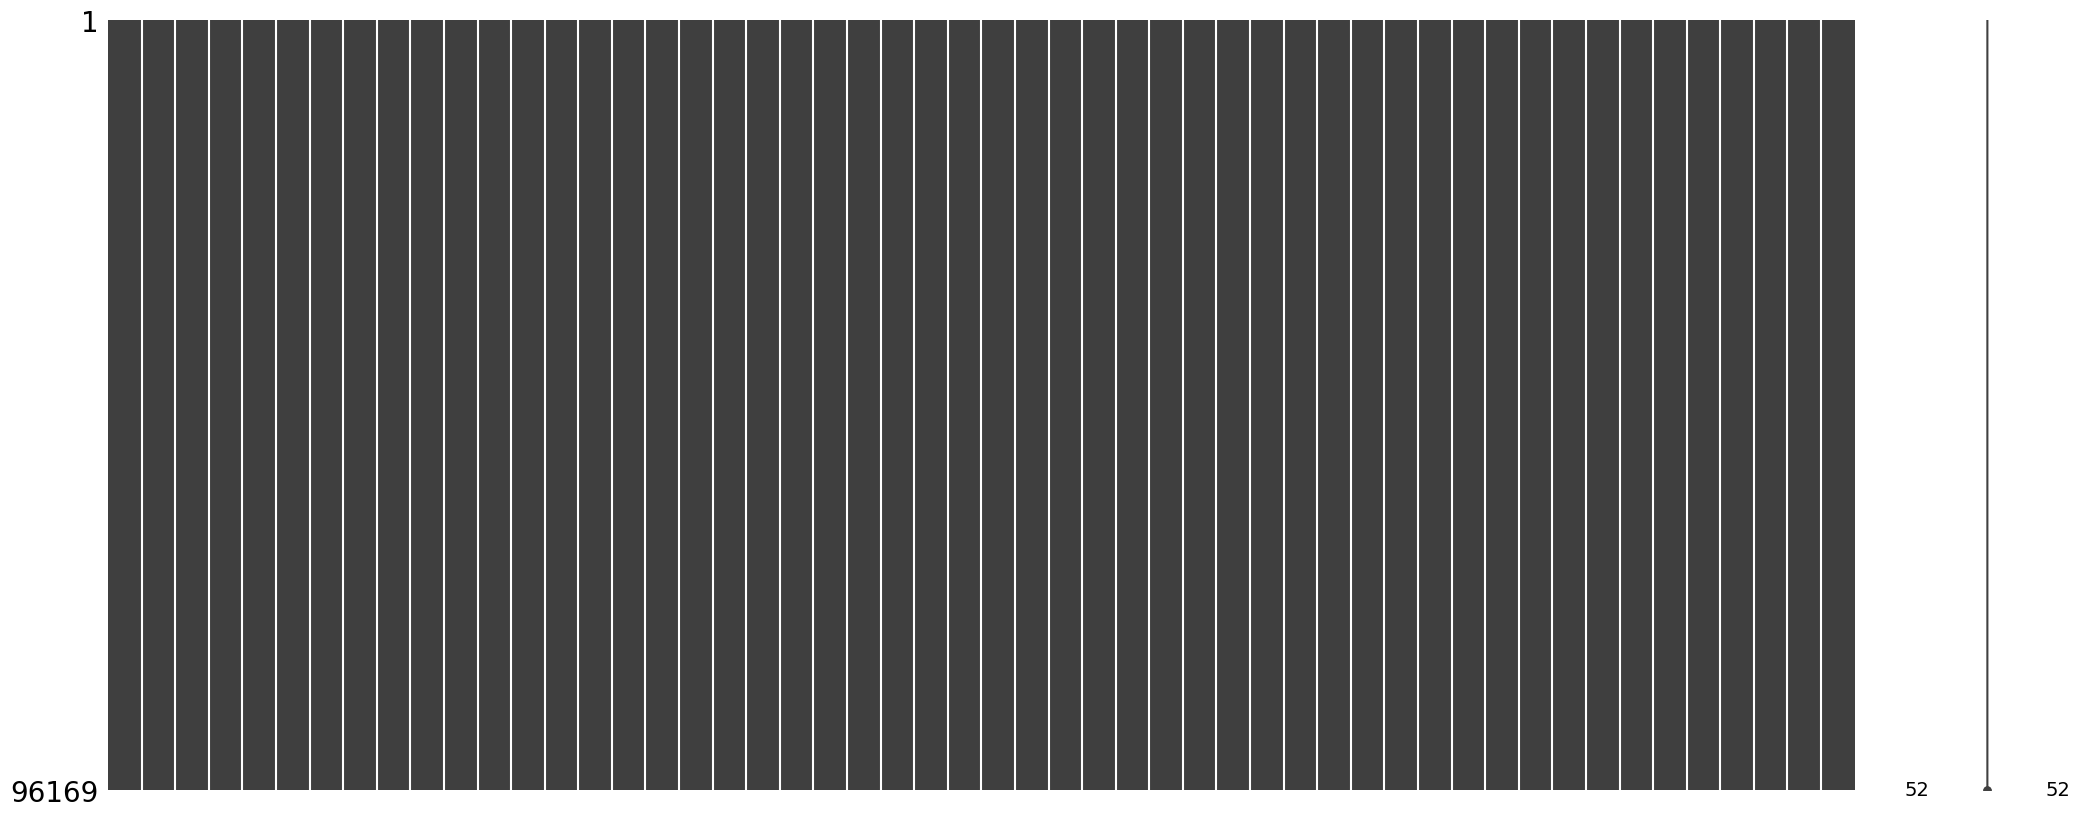

In [49]:
import missingno as msno
msno.matrix(df)

In [50]:
df.duplicated().sum()

np.int64(0)

In [51]:
# Count how many rows for each assists value
df['goals_conceded'].value_counts() #bonus

,count
goals_conceded,
0,69673
1,13607
2,7425
3,3503
4,1345
5,446
6,110
7,43
9,16


In [52]:
# dih kan fiha bigger than zero bardo
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

players_with_points_but_no_minutes = df[(df['minutes'] == 0) & (df['total_points'] < 0)] #mara bl >0 as well

cols_to_show = [
    'season_x', 'GW', 'name', 'team_x',
    'minutes', 'total_points', 'position'
]
print(players_with_points_but_no_minutes[cols_to_show].to_string(index=False))

print("\nCount:", len(players_with_points_but_no_minutes))


season_x  GW                      name    team_x  minutes  total_points position
 2017-18  38 Ederson Santana de Moraes  Man City        0            -1       GK
 2017-18  17                 Sam Field West Brom        0            -1      MID
 2020-21  37            Daniel Amartey Leicester        0            -1      DEF
 2021-22  30              Nohan Kenneh     Leeds        0            -1      MID
 2022-23  16          Jamaal Lascelles Newcastle        0            -1      DEF
 2022-23  19          Jamaal Lascelles Newcastle        0            -1      DEF
 2022-23  28        Matheus Luiz Nunes    Wolves        0            -3      MID

Count: 7


In [53]:
df['clean_sheets'].value_counts()

,count
clean_sheets,
0,85904
1,10265


In [54]:
df_gk = df[df['position'].isin(['GK'])].copy()

df_gk['expected_points'] = 0

df_gk.loc[(df_gk['minutes'] > 0) & (df_gk['minutes'] < 60), 'expected_points'] += 1
df_gk.loc[df_gk['minutes'] >= 60, 'expected_points'] += 2

df_gk['expected_points'] += (
    6 * df_gk['goals_scored'] +                               # goals scored (rare for GKs)
    3 * df_gk['assists'] +                                    # assists (+3 each)
    4 * df_gk['clean_sheets'] * (df_gk['minutes'] >= 60) +    # clean sheets (60+ mins)
    (-1) * np.floor(df_gk['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    np.floor(df_gk['saves'] / 3) +                            # +1 per 3 saves
    5 * df_gk['penalties_saved'] +                            # +5 per penalty saved
    (-2) * df_gk['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_gk['own_goals'] +                               # -2 per own goal
    (-3) * df_gk['red_cards'] +                               # -3 per red card
    (-1) * df_gk['yellow_cards'] +                            # -1 per yellow card
    df_gk['bonus']                                            # bonus points
)

df_gk['difference'] = df_gk['total_points'] - df_gk['expected_points']

In [55]:
inconsistencies = df_gk[df_gk['difference'] != 0]

print("Number of inconsistent goalkeeper rows:", len(inconsistencies))


Number of inconsistent goalkeeper rows: 0


In [56]:
cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

inconsistencies[cols_to_show]

,season_x,GW,name,team_x,minutes,expected_points,total_points,difference


In [57]:
unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent goalkeeper: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


Number of unique inconsistent goalkeeper: 0
Players with inconsistencies:
[]


In [58]:
player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per goalkeeper:")
print(player_counts)


Inconsistency frequency per goalkeeper:
Series([], Name: count, dtype: int64)


In [59]:
pd.set_option('display.max_rows', None)

df_def = df[df['position'] == 'DEF'].copy()

df_def['expected_points'] = 0

df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2

df_def['expected_points'] += (
    6 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    4 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    (-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)

In [60]:
df_def['difference'] = df_def['total_points'] - df_def['expected_points']

inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent defender rows:", len(inconsistencies))

Number of inconsistent defender rows: 0


In [61]:
cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

print(inconsistencies[cols_to_show])

Empty DataFrame
Columns: [season_x, GW, name, team_x, minutes, expected_points, total_points, difference]
Index: []


In [62]:
unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent defenders: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


Number of unique inconsistent defenders: 0
Players with inconsistencies:
[]


In [63]:
player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per defender:")
print(player_counts)


Inconsistency frequency per defender:
Series([], Name: count, dtype: int64)


In [64]:
pd.set_option('display.max_rows', None)

df_def = df[df['position'] == 'MID'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    5 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    1 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    #(-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']

In [65]:
inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent midfielders rows:", len(inconsistencies))

Number of inconsistent midfielders rows: 0


In [66]:
cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

inconsistencies[cols_to_show]

,season_x,GW,name,team_x,minutes,expected_points,total_points,difference


In [67]:
unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent midfielders: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


Number of unique inconsistent midfielders: 0
Players with inconsistencies:
[]


In [68]:
player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per midfielders:")
print(player_counts)


Inconsistency frequency per midfielders:
Series([], Name: count, dtype: int64)


In [69]:
pd.set_option('display.max_rows', None)


df_def = df[df['position'] == 'FWD'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    4 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    #1 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    #(-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']

In [70]:
inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent attacker rows:", len(inconsistencies))

Number of inconsistent attacker rows: 0


In [71]:
cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

print(inconsistencies[cols_to_show])

Empty DataFrame
Columns: [season_x, GW, name, team_x, minutes, expected_points, total_points, difference]
Index: []


In [72]:
unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent attackers: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


Number of unique inconsistent attackers: 0
Players with inconsistencies:
[]


In [73]:
player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per attackers:")
print(player_counts)


Inconsistency frequency per attackers:
Series([], Name: count, dtype: int64)


In [74]:
player_gw_counts = df.groupby(['season_x', 'name'])['GW'].count().reset_index(name='matches_played')


season_summary = player_gw_counts.groupby('season_x').agg(
    unique_players=('name', 'nunique'),
    total_matches=('matches_played', 'sum')
).reset_index()

pd.set_option('display.max_rows', None)
print(season_summary)


  season_x  unique_players  total_matches
0  2016-17             243           8567
1  2017-18             315          11285
2  2020-21             712          24365
3  2021-22             735          25447
4  2022-23             777          26505


In [75]:
def player_match_distribution(df):
    """
    Returns, for each season, how many players appeared in how many matches.
    Example: 'In 2022-23, 110 players appeared 38 times, 45 appeared 37 times, etc.'
    """
    player_match_counts = (
        df.groupby(['season_x', 'name'])
        .size()
        .reset_index(name='matches_played')
    )

    distribution = (
        player_match_counts.groupby(['season_x', 'matches_played'])
        .size()
        .reset_index(name='player_count')
        .sort_values(['season_x', 'matches_played'], ascending=[True, False])
    )

    return distribution

In [76]:
result = player_match_distribution(df)
pd.set_option('display.max_rows', None)
print(result)

    season_x  matches_played  player_count
18   2016-17              38           195
17   2016-17              37             3
16   2016-17              36             3
15   2016-17              35            12
14   2016-17              31             1
13   2016-17              30             2
12   2016-17              29             2
11   2016-17              26             1
10   2016-17              24             1
9    2016-17              23             3
8    2016-17              22             1
7    2016-17              21             1
6    2016-17              19             1
5    2016-17              18             3
4    2016-17              15             5
3    2016-17              11             2
2    2016-17              10             2
1    2016-17               5             3
0    2016-17               1             2
42   2017-18              38           270
41   2017-18              36             5
40   2017-18              35             4
39   2017-1

In [77]:
df_season = df[df['season_x'] == '2021-22']

gw_counts = df_season.groupby('name')['GW'].count().sort_values(ascending=False)

pd.set_option('display.max_rows', None)
print(gw_counts)

name
Ben Davies                                    76
Álvaro Fernández                              42
Donny van de Beek                             40
Dan Burn                                      39
Anwar El Ghazi                                39
João Pedro Cavaco Cancelo                     38
João Filipe Iria Santos Moutinho              38
Kurt Zouma                                    38
José Malheiro de Sá                           38
José Diogo Dalot Teixeira                     38
Ken Sema                                      38
Joshua Sargent                                38
Joshua King                                   38
Kwadwo Baah                                   38
Josh Martin                                   38
Kevin De Bruyne                               38
Kepa Arrizabalaga                             38
Kenny McLean                                  38
Reece Hannam                                  38
Reiss Nelson                                  38
Juraj Kucka    

In [78]:
def find_players_with_multiple_elements(df):

    grouped = (
        df.groupby(['season_x', 'name'])['element']
        .nunique()
        .reset_index(name='unique_elements')
    )

    multi_element_players = grouped[grouped['unique_elements'] > 1]

    detailed = (
        df[df['name'].isin(multi_element_players['name'])]
        .groupby(['season_x', 'name'])['element']
        .unique()
        .reset_index()
    )

    return detailed

In [79]:
result = find_players_with_multiple_elements(df)
print(result)

  season_x              name     element
0  2016-17        Ben Davies       [386]
1  2017-18        Ben Davies       [381]
2  2020-21        Ben Davies  [395, 653]
3  2021-22        Ben Davies  [248, 364]
4  2021-22  Álvaro Fernández  [556, 728]
5  2022-23        Ben Davies  [432, 499]


In [80]:
#CHECKING IF OUTLIERS EXIST IN TOTAL_POINTS

min_points = df["total_points"].min()
max_points = df["total_points"].max()

print(f"Minimum total_points: {min_points}")
print(f"Maximum total_points: {max_points}")

Minimum total_points: -7
Maximum total_points: 29


In [81]:
#CHECKING THAT THERE ARE 380 FIXTURES PER SEASON

fixtures_per_season = df.groupby("season_x")["fixture"].nunique().reset_index(name="fixture_count")
print("Fixtures per season:")
print(fixtures_per_season)

#creating the boolean that checks
all_380 = (fixtures_per_season["fixture_count"] == 380).all()
print(f"\n All seasons have 380 fixtures: {all_380}")

Fixtures per season:
  season_x  fixture_count
0  2016-17            380
1  2017-18            380
2  2020-21            380
3  2021-22            380
4  2022-23            380

 All seasons have 380 fixtures: True


In [82]:
#CHECKING IF GK HAS OWN GOALS

df["own_goals"] = pd.to_numeric(df["own_goals"], errors="coerce").fillna(0)

gk_with_own_goals = df[(df["position"] == "GK") & (df["own_goals"] != 0)]

# Counting how many records for gk has own goals more than zero
count = len(gk_with_own_goals)

if count > 0:
    print(f" Found {count} goalkeeper(s) with own goals:")
    for _, row in gk_with_own_goals.iterrows():
        print(f"Season: {row['season_x']} | Name: {row['name']} | Own goals: {row['own_goals']}")
else:
    print("No goalkeepers with own goals found.")


 Found 16 goalkeeper(s) with own goals:
Season: 2017-18 | Name: Jonas Lössl | Own goals: 1
Season: 2017-18 | Name: Kasper Schmeichel | Own goals: 1
Season: 2017-18 | Name: Karl Darlow | Own goals: 1
Season: 2017-18 | Name: Jack Butland | Own goals: 1
Season: 2020-21 | Name: Bernd Leno | Own goals: 1
Season: 2020-21 | Name: Illan Meslier | Own goals: 1
Season: 2020-21 | Name: Kasper Schmeichel | Own goals: 1
Season: 2021-22 | Name: Alisson Ramses Becker | Own goals: 1
Season: 2021-22 | Name: Tim Krul | Own goals: 1
Season: 2021-22 | Name: José Malheiro de Sá | Own goals: 1
Season: 2021-22 | Name: Álvaro Fernández | Own goals: 1
Season: 2022-23 | Name: Emiliano Martínez Romero | Own goals: 1
Season: 2022-23 | Name: David Raya Martin | Own goals: 1
Season: 2022-23 | Name: Jason Steele | Own goals: 1
Season: 2022-23 | Name: Hugo Lloris | Own goals: 1
Season: 2022-23 | Name: Daniel Iversen | Own goals: 1


In [83]:
#CHECKING IF ANY PLAYER THAT IS NOT GK HAVE VALUES GREATER THAN ZERO IN PEN SAVED AND SAVES

for col in ["penalties_saved", "saves"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

non_gk = df["position"] != "GK"

mistakes = df[non_gk & ((df["penalties_saved"] != 0) | (df["saves"] != 0))]

# Count how many mistakes
mistake_count = len(mistakes)

print(f"Found {mistake_count} wrongly assigned players (non-GKs with saves or penalties_saved > 0).")

if mistake_count > 0:
    display(mistakes)


Found 0 wrongly assigned players (non-GKs with saves or penalties_saved > 0).


In [84]:
#VISUALS
#VISUALS
#VISUALS
#VISUALS
#VISUALS

  position  total_points
0      MID       11587.8
1      DEF        8617.6
2      FWD        3860.0
3       GK        2463.2


/tmp/ipython-input-1877319910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_pos_points, x="position", y="total_points", palette="viridis")


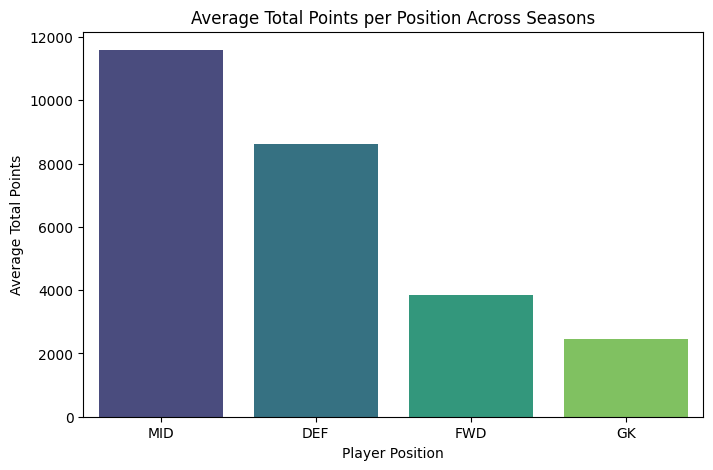

In [85]:
# Group by season and position
pos_points = (
    df.groupby(["season_x", "position"])["total_points"]
    .sum()
    .reset_index()
)

# Compute the average across all seasons for each position
avg_pos_points = (
    pos_points.groupby("position")["total_points"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print(avg_pos_points)

plt.figure(figsize=(8,5))
sns.barplot(data=avg_pos_points, x="position", y="total_points", palette="viridis")

plt.title("Average Total Points per Position Across Seasons")
plt.xlabel("Player Position")
plt.ylabel("Average Total Points")
plt.show()


In [86]:
df_season = df[df['season_x'] == '2022-23']

# Sort by form and get the top 5 players
top_5_form = df_season[['name', 'form']].sort_values(by='form', ascending=False).head(5)

print(top_5_form)

                   name      form
73848  Leandro Trossard  1.600000
83532      Fabian Schär  1.500000
73576       Pascal Groß  1.500000
81714    Erling Haaland  1.433333
81709    Erling Haaland  1.300000


Top 5 players with the highest instances of form in season 2022-23: ['Leandro Trossard', 'Fabian Schär', 'Pascal Groß', 'Erling Haaland', 'Dejan Kulusevski']


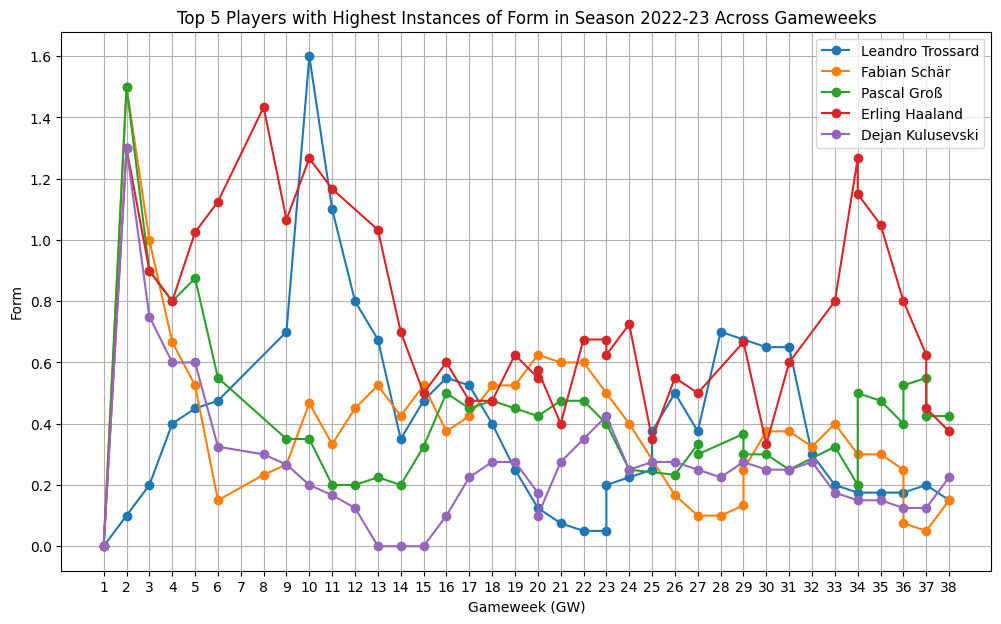

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter season 2022-23
df_season = df[df['season_x'] == '2022-23'].copy()

# Ensure GW is numeric
df_season['GW'] = pd.to_numeric(df_season['GW'], errors='coerce')

# Take top 6 rows because one player may appear twice
top_6 = df_season[['name', 'form']].sort_values(by='form', ascending=False).head(6)

# Keep the first occurrence of each player name (top 5 unique players)
top_5_unique_players = top_6.drop_duplicates(subset='name').head(5)['name'].tolist()

print("Top 5 players with the highest instances of form in season 2022-23:", top_5_unique_players)

# Plot their form across 38 GWs
plt.figure(figsize=(12, 7))

for player in top_5_unique_players:
    player_data = df_season[df_season['name'] == player].sort_values(by='GW')
    plt.plot(player_data['GW'], player_data['form'], marker='o', label=player)

plt.title("Top 5 Players with Highest Instances of Form in Season 2022-23 Across Gameweeks")
plt.xlabel("Gameweek (GW)")
plt.ylabel("Form")
plt.xticks(range(1, 39))  # show GW 1 → 38
plt.grid(True)
plt.legend()
plt.show()

In [88]:
season_df = df[df["season_x"] == "2022-23"].copy()
top5_total = (
    season_df.groupby(["element", "name"])["total_points"]
    .sum()
    .nlargest(5)
    .reset_index()
)

print("Top 5 players by total points:")
print(top5_total)



Top 5 players by total points:
   element             name  total_points
0      318   Erling Haaland           272
1      427       Harry Kane           263
2      283    Mohamed Salah           239
3        7  Martin Ødegaard           212
4      335  Marcus Rashford           205


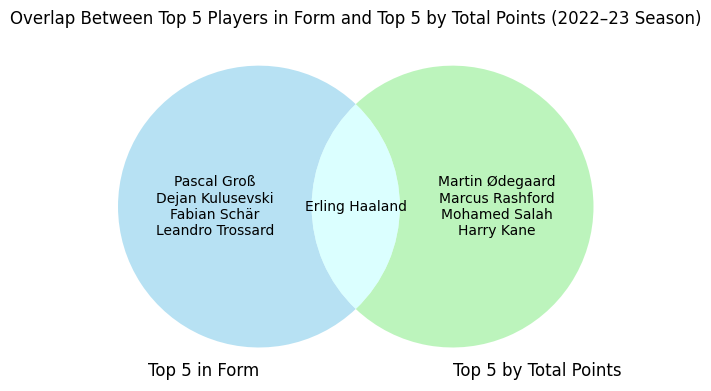

In [89]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Define sets
form_set = set(top_5_unique_players)
total_set = set(top5_total["name"])

# Calculate overlaps
only_form = form_set - total_set
only_total = total_set - form_set
both = form_set & total_set

# Plot Venn
plt.figure(figsize=(7,7))
venn = venn2(
    [form_set, total_set],
    set_labels=("Top 5 in Form", "Top 5 by Total Points"),
    set_colors=('skyblue', 'lightgreen'),
    alpha=0.6
)

# Replace counts with player names
venn.get_label_by_id('10').set_text('\n'.join(only_form) if only_form else "")
venn.get_label_by_id('01').set_text('\n'.join(only_total) if only_total else "")
venn.get_label_by_id('11').set_text('\n'.join(both) if both else "")

# Style
for label in venn.set_labels:
    label.set_fontsize(12)
for label in venn.subset_labels:
    if label:
        label.set_fontsize(10)

plt.title("Overlap Between Top 5 Players in Form and Top 5 by Total Points (2022–23 Season)")
plt.show()


In [90]:

#MODEL
#MODEL
#MODEL
#MODEL
#MODEL
#MODEL

In [91]:
df = df[df['GW'] != 38]
print(df['GW'].unique())
output_path = "team_6_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 29 30 31 32 33 34 35 36 37 26 28]
Saved to: team_6_cleaned.csv


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [93]:
# MODEL ME3AFEN AWY BEGAD W MAFEEHOOSH ONE HOT ENCODING LEL POSITION

In [94]:
feature_set = [
     "position", "assists", "bonus", "clean_sheets",
     "goals_conceded", "goals_scored", "ict_index", "minutes",
     "own_goals", "penalties_missed", "penalties_saved", "saves",
     "total_points"]

In [95]:
target = "upcoming_total_points"

In [96]:
X = df[feature_set].copy()
y = df[target]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Encode position
le = LabelEncoder()
# Apply encoding to the original DataFrame column
df["position_encoded"] = le.fit_transform(df["position"])

In [99]:
# Create scaler and fit
scaler = StandardScaler()

# Fit scaler only on training data, then transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [100]:
# Update column names to use the encoded/integer versions
X_train_scaled['position'] = df.loc[X_train_scaled.index, 'position_encoded']
X_test_scaled['position'] = df.loc[X_test_scaled.index, 'position_encoded']

In [101]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)), # Updated input shape
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
# Compile model with appropriate loss and metrics for regression
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # or 'categorical_crossentropy' if multi-class
    metrics=['accuracy']          # <-- add accuracy metric here
)

In [104]:
early_stop = EarlyStopping(
    monitor='val_loss',    # what to monitor
    patience=5,            # number of epochs to wait for improvement
    restore_best_weights=True,  # revert to best model after stopping
    verbose=1
)

In [105]:
# Fit model with early stopping
history = model.fit(
    X_train_scaled, y_train, # Use scaled data
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5653 - loss: -10.8726 - val_accuracy: 0.5767 - val_loss: -11.6264
Epoch 2/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5718 - loss: -11.5253 - val_accuracy: 0.5760 - val_loss: -11.6434
Epoch 3/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5801 - loss: -11.6935 - val_accuracy: 0.5760 - val_loss: -11.6226
Epoch 4/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5804 - loss: -11.5485 - val_accuracy: 0.5760 - val_loss: -11.6621
Epoch 5/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5833 - loss: -11.9658 - val_accuracy: 0.5760 - val_loss: -11.6597
Epoch 6/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5830 - loss: -11.6851 - val_accuracy: 0.5762 - val_loss: -11.6414
Epoch 7/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5795 - loss: -11.6146 - val_accuracy: 0.5760 - val_loss: -11.6615
Epoch 8/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accura

In [106]:
# Use scaled data for prediction
y_pred = model.predict(X_test_scaled).flatten()

584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [107]:
# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [108]:
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")

Mean Absolute Error (MAE): 16.979
Mean Squared Error (MSE): 720.962
Root Mean Squared Error (RMSE): 26.851
R-squared (R²): -111.942


In [109]:
# LINEAR REGRESSION MODEL BAS MEN GHEIR NEW FEATURES W BADA2NA NETNAFES

In [110]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points"
]

In [111]:
target = "upcoming_total_points"

In [112]:
X = df[feature_set].copy()
y = df[target]

In [113]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'position_FWD',
       'position_GK', 'position_MID'],
      dtype='object')


In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [115]:
# We scale only numerical columns (excluding dummy variables)
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "total_points"
]

scaler = StandardScaler()

In [116]:
# Fit scaler on training data and transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [117]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [118]:
y_pred = model.predict(X_test_scaled)

In [119]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [120]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.283
Mean Squared Error (MSE): 4.752
Root Mean Squared Error (RMSE): 2.180
R-squared (R²): 0.256


In [121]:
# Show how each feature influences the prediction
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [122]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
             Feature  Coefficient
6            minutes     0.889001
11      total_points     0.338549
12      position_FWD     0.329220
5          ict_index     0.326122
14      position_MID     0.144581
10             saves     0.079171
8   penalties_missed     0.047402
7          own_goals     0.027365
13       position_GK    -0.011415
9    penalties_saved    -0.023994
3     goals_conceded    -0.044121
0            assists    -0.049414
2       clean_sheets    -0.068802
4       goals_scored    -0.080491
1              bonus    -0.152235


In [123]:
# RANDOM FOREST REGRESSOR MAKANSH LAZEEZ

In [124]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points"
]

In [125]:
target = "upcoming_total_points"

In [126]:
X = df[feature_set].copy()
y = df[target]

In [127]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'position_FWD',
       'position_GK', 'position_MID'],
      dtype='object')


In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [129]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "total_points"
]

In [130]:
scaler = StandardScaler()

In [131]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [132]:
model = RandomForestRegressor(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees expand until all leaves are pure
    random_state=42,
    n_jobs=-1              # use all CPU cores for speed
)

In [133]:
model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [134]:
y_pred = model.predict(X_test_scaled)

In [135]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [136]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.350
Mean Squared Error (MSE): 5.486
Root Mean Squared Error (RMSE): 2.342
R-squared (R²): 0.141


In [137]:
# LINEAR REGRESSION TANY BAS ESTA3MELNA NEW FEATURE EL HEYA "minutes_ict"

In [138]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_ict"
]

In [139]:
target = "upcoming_total_points"

In [140]:
X = df[feature_set].copy()
y = df[target]

In [141]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_ict',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [143]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "total_points", "minutes_ict"
]

In [144]:
scaler = StandardScaler()

In [145]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [146]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [147]:
y_pred = model.predict(X_test_scaled)

In [148]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [149]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.281
Mean Squared Error (MSE): 4.750
Root Mean Squared Error (RMSE): 2.179
R-squared (R²): 0.256


In [150]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [151]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
             Feature  Coefficient
6            minutes     0.927161
5          ict_index     0.729606
13      position_FWD     0.301931
11      total_points     0.289671
15      position_MID     0.128404
10             saves     0.080423
8   penalties_missed     0.047420
7          own_goals     0.025476
14       position_GK    -0.008212
9    penalties_saved    -0.022281
0            assists    -0.042118
3     goals_conceded    -0.048587
2       clean_sheets    -0.056130
4       goals_scored    -0.073854
1              bonus    -0.126356
12       minutes_ict    -0.422877


In [152]:
# LINEAR REGRESSION B 2 FEATURES ("minutes_ict", "minutes_points")

In [153]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_ict", "minutes_points"
]

In [154]:
target = "upcoming_total_points"

In [155]:
X = df[feature_set].copy()
y = df[target]

In [156]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_ict',
       'minutes_points', 'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [158]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "total_points", "minutes_ict", "minutes_points"
]

In [159]:
scaler = StandardScaler()

In [160]:
# Fit scaler on training data and transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [161]:
model = LinearRegression()

In [162]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [163]:
y_pred = model.predict(X_test_scaled)

In [164]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [165]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.277
Mean Squared Error (MSE): 4.747
Root Mean Squared Error (RMSE): 2.179
R-squared (R²): 0.256


In [166]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [167]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
             Feature  Coefficient
6            minutes     0.935854
11      total_points     0.785960
5          ict_index     0.347370
14      position_FWD     0.289284
16      position_MID     0.119290
10             saves     0.081951
8   penalties_missed     0.048060
7          own_goals     0.025014
15       position_GK     0.000570
9    penalties_saved    -0.020435
12       minutes_ict    -0.023793
0            assists    -0.044969
2       clean_sheets    -0.045815
3     goals_conceded    -0.051575
4       goals_scored    -0.081035
1              bonus    -0.111661
13    minutes_points    -0.530354


In [168]:
# LINEAR REGRESSION HATEINA EL "form", shelna "minutes_ict", hateina, "minutes_points"

In [169]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form"
]

In [170]:
target = "upcoming_total_points"

In [171]:
# Select features (X) and target (y)
X = df[feature_set].copy()
y = df[target]

In [172]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points', 'form',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [173]:
X_train, X_test, y_train, y_testt = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [174]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "total_points", "minutes_points", "form"
]

In [175]:
scaler = StandardScaler()

In [176]:
# Fit scaler on training data and transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [177]:
model = LinearRegression()

In [178]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [179]:
y_predd = model.predict(X_test_scaled)

In [180]:
mae = mean_absolute_error(y_testt, y_predd)
mse = mean_squared_error(y_testt, y_predd)
rmse = np.sqrt(mse)
r2 = r2_score(y_testt, y_predd)

In [181]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.238
Mean Squared Error (MSE): 4.633
Root Mean Squared Error (RMSE): 2.152
R-squared (R²): 0.274


In [182]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [183]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
             Feature  Coefficient
11      total_points     0.724680
6            minutes     0.720064
13              form     0.451609
5          ict_index     0.250803
14      position_FWD     0.221400
16      position_MID     0.087571
10             saves     0.055729
8   penalties_missed     0.041637
7          own_goals     0.022070
15       position_GK     0.018681
9    penalties_saved    -0.016645
0            assists    -0.037136
2       clean_sheets    -0.042719
3     goals_conceded    -0.042989
4       goals_scored    -0.071514
1              bonus    -0.090860
12    minutes_points    -0.497195


In [184]:
tolerance = 2
accuracy_like = np.mean(np.abs(y_testt - y_predd) <= tolerance)
print(f"Prediction Accuracy (within ±2 pts): {accuracy_like:.2%}")

Prediction Accuracy (within ±2 pts): 80.43%


In [185]:
# LINEAR REGRESSION BEL "form_avg" badal "form", w "minutes_points"

In [186]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg"
]

In [187]:
target = "upcoming_total_points"

In [188]:
X = df[feature_set].copy()
y = df[target]

In [189]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [190]:
X_train, X_test, y_train, y_testt = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [191]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "form_avg"
]

In [192]:
scaler = StandardScaler()

In [193]:
# Fit scaler on training data and transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [194]:
model = LinearRegression()

In [195]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [196]:
y_predd = model.predict(X_test_scaled)

In [197]:
mae = mean_absolute_error(y_testt, y_predd)
mse = mean_squared_error(y_testt, y_predd)
rmse = np.sqrt(mse)
r2 = r2_score(y_testt, y_predd)

In [198]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.238
Mean Squared Error (MSE): 4.633
Root Mean Squared Error (RMSE): 2.152
R-squared (R²): 0.274


In [199]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [200]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
             Feature  Coefficient
6            minutes     0.720064
13          form_avg     0.451609
11      total_points     0.286047
5          ict_index     0.250803
14      position_FWD     0.221400
16      position_MID     0.087571
10             saves     0.055729
8   penalties_missed     0.041637
7          own_goals     0.022070
15       position_GK     0.018681
12    minutes_points    -0.002262
9    penalties_saved    -0.016645
0            assists    -0.037136
2       clean_sheets    -0.042719
3     goals_conceded    -0.042989
4       goals_scored    -0.071514
1              bonus    -0.090860


In [201]:
# LINEAR REGRESSION ESTA3MELNA "form_avg" , "minutes_formAvg"

In [202]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg", "minutes_form_avg"
]

In [203]:
target = "upcoming_total_points"

In [204]:
X = df[feature_set].copy()
y = df[target]

In [205]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'minutes_form_avg', 'position_FWD', 'position_GK',
       'position_MID'],
      dtype='object')


In [206]:
X_train, X_test, y_train, y_testt = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [207]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "form_avg", "minutes_form_avg"
]

In [208]:
scaler = StandardScaler()

In [209]:
# Fit scaler on training data and transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [210]:
model = LinearRegression()

In [211]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [212]:
y_predd = model.predict(X_test_scaled)

In [213]:
mae = mean_absolute_error(y_testt, y_predd)
mse = mean_squared_error(y_testt, y_predd)
rmse = np.sqrt(mse)
r2 = r2_score(y_testt, y_predd)

In [214]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.229
Mean Squared Error (MSE): 4.630
Root Mean Squared Error (RMSE): 2.152
R-squared (R²): 0.275


In [215]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [216]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
             Feature  Coefficient
6            minutes     0.821321
13          form_avg     0.694160
5          ict_index     0.268831
11      total_points     0.223069
15      position_FWD     0.217290
17      position_MID     0.080969
16       position_GK     0.062864
10             saves     0.058372
8   penalties_missed     0.042002
7          own_goals     0.021443
12    minutes_points    -0.001590
9    penalties_saved    -0.017163
0            assists    -0.030774
2       clean_sheets    -0.038955
3     goals_conceded    -0.048285
4       goals_scored    -0.059738
1              bonus    -0.092452
14  minutes_form_avg    -0.348693


In [217]:
# # Add the missing feature columns
# df['minutes_formAvg'] = df['minutes'] * df['form_avg']
# df["form_minutes_ratio_metsala7_avg"] = df["form_avg"] / (df["minutes"] + 1)
# df['form_avg_sa7'] = df['form_avg']

In [218]:
# LINEAR REGRESSION W ESTA3MELNA "minutes_points", "form_avg", "minutes_formAvg", "is_home_int",
#    "goal_contrib", "defensive_contrib", "form_minutes_ratio", "ict_per_minute"

In [219]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib", "form_minutes_ratio", "ict_per_minute"
]

In [220]:
target = "upcoming_total_points"

In [221]:
X = df[feature_set].copy()
y = df[target]

In [222]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'minutes_form_avg', 'is_home_int', 'goal_contrib',
       'defensive_contrib', 'form_minutes_ratio', 'ict_per_minute',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [223]:
X_train, X_test, y_train, y_testt = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [224]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib", "form_minutes_ratio", "ict_per_minute"
]

In [225]:
scaler = StandardScaler()

In [226]:
# Fit scaler on training data and transform both
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [227]:
model = LinearRegression()

In [228]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [229]:
y_predd = model.predict(X_test_scaled)

In [230]:
mae = mean_absolute_error(y_testt, y_predd)
mse = mean_squared_error(y_testt, y_predd)
rmse = np.sqrt(mse)
r2 = r2_score(y_testt, y_predd)

In [231]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.229
Mean Squared Error (MSE): 4.626
Root Mean Squared Error (RMSE): 2.151
R-squared (R²): 0.275


In [232]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [233]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
               Feature  Coefficient
6              minutes     0.823705
13            form_avg     0.746070
5            ict_index     0.255799
20        position_FWD     0.213508
11        total_points     0.188826
22        position_MID     0.078410
21         position_GK     0.062286
10               saves     0.058459
8     penalties_missed     0.041735
19      ict_per_minute     0.022046
7            own_goals     0.021032
17   defensive_contrib     0.019115
12      minutes_points    -0.001217
0              assists    -0.008991
9      penalties_saved    -0.017198
18  form_minutes_ratio    -0.027386
16        goal_contrib    -0.029591
3       goals_conceded    -0.034339
4         goals_scored    -0.034471
2         clean_sheets    -0.041745
15         is_home_int    -0.051315
1                bonus    -0.092102
14    minutes_form_avg    -0.399778


Feature columns after encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'minutes_form_avg', 'is_home_int', 'goal_contrib',
       'defensive_contrib', 'formAvg_minutes_ratio', 'ict_per_minute',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')

📊 XGBoost Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.211
Mean Squared Error (MSE): 4.655
Root Mean Squared Error (RMSE): 2.158
R-squared (R²): 0.271


<Figure size 1000x800 with 0 Axes>

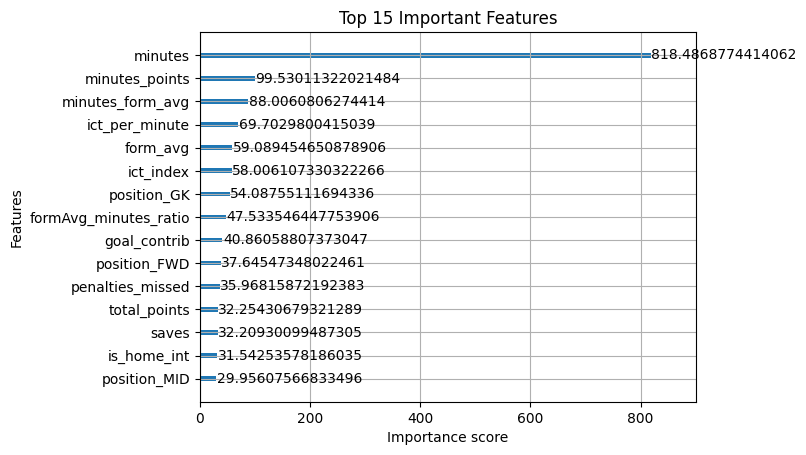

In [309]:
#We tried XG boost but the results were similar to our models so we went back to FNN and linear regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt


feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib", "formAvg_minutes_ratio", "ict_per_minute"
]

target = "upcoming_total_points"

X = df[feature_set].copy()
y = df[target]


X = pd.get_dummies(X, columns=['position'], drop_first=True)
print("Feature columns after encoding:\n", X.columns)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "form_avg",
    "minutes_form_avg", "is_home_int", "goal_contrib",
    "defensive_contrib", "formAvg_minutes_ratio", "ict_per_minute"
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])


xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train_scaled, y_train)


y_pred = xgb_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📊 XGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")

plt.figure(figsize=(10,8))
plot_importance(xgb_model, importance_type='gain', max_num_features=15, title='Top 15 Important Features')
plt.show()


In [234]:
tolerance = 1
accuracy_like = np.mean(np.abs(y_testt - y_predd) <= tolerance)
print(f"Prediction Accuracy (within ±1 pts): {accuracy_like:.2%}")

Prediction Accuracy (within ±1 pts): 64.53%


In [235]:
# BACK TO shallow feed-forward neural network JUST TO TEST

In [236]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg", "minutes_form_avg",
    "is_home_int", "goal_contrib", "defensive_contrib",
    "form_minutes_ratio", "ict_per_minute"
]

In [237]:
target = "upcoming_total_points"

In [238]:
X = df[feature_set].copy()
y = df[target]

In [239]:
# One-hot encode the position column (MID, DEF, FWD, GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'minutes_form_avg', 'is_home_int', 'goal_contrib',
       'defensive_contrib', 'form_minutes_ratio', 'ict_per_minute',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [240]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [241]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves",
    "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib",
    "form_minutes_ratio", "ict_per_minute"
]

In [242]:
scaler = StandardScaler()

In [243]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [244]:
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [245]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error = "accuracy-style" metric
)

In [246]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,        # Wait 10 epochs with no improvement
    restore_best_weights=True
)

In [247]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 20.5591 - mae: 1.9594 - val_loss: 5.1101 - val_mae: 1.1555
Epoch 2/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.1347 - mae: 1.2655 - val_loss: 4.9838 - val_mae: 1.1616
Epoch 3/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9053 - mae: 1.2503 - val_loss: 4.6588 - val_mae: 1.1830
Epoch 4/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9585 - mae: 1.2571 - val_loss: 4.7509 - val_mae: 1.3006
Epoch 5/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9639 - mae: 1.2475 - val_loss: 4.6653 - val_mae: 1.2295
Epoch 6/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.8257 - mae: 1.2384 - val_loss: 4.6478 - val_mae: 1.2343
Epoch 7/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.8236 - mae: 1.2377 - val_loss: 4.6591 - val_mae: 1.2044
Epoch 8/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.7614 - mae: 1.2331 - val_loss: 4.6482 - val_mae: 1.2343
Epoch 9/50
1868/1868 ━━━━━━━━━━━━━━━━━━

In [248]:
y_pred = model.predict(X_test_scaled).flatten()

584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [249]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [250]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.232
Mean Squared Error (MSE): 4.615
Root Mean Squared Error (RMSE): 2.148
R-squared (R²): 0.277


In [251]:
plt.figure(figsize=(10,4))

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

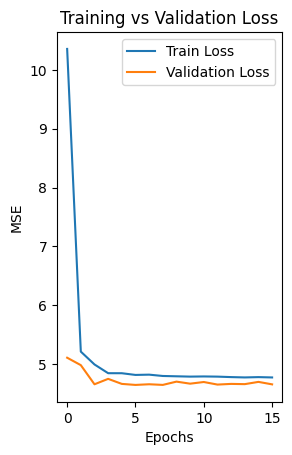

In [252]:
# Loss (MSE)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

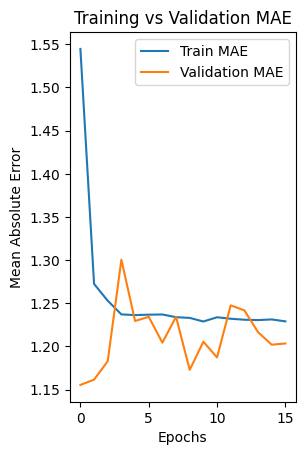

In [253]:
# MAE (Accuracy-like)
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

In [254]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [255]:
# ALSO BACK TO shallow feed-forward neural network BUT WE ADDED A LAYER AND learning_rate

In [256]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg", "minutes_form_avg",
    "is_home_int", "goal_contrib", "defensive_contrib",
    "form_minutes_ratio", "ict_per_minute"
]

In [257]:
target = "upcoming_total_points"

In [258]:
X = df[feature_set].copy()
y = df[target]

In [259]:
# One-hot encode the position column (MID, DEF, FWD, GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'minutes_form_avg', 'is_home_int', 'goal_contrib',
       'defensive_contrib', 'form_minutes_ratio', 'ict_per_minute',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [260]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [261]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves",
    "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib",
    "form_minutes_ratio", "ict_per_minute"
]

In [262]:
scaler = StandardScaler()

In [263]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [264]:
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [265]:
model.compile(
    optimizer = Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error = "accuracy-style" metric
)

In [266]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # Wait 10 epochs with no improvement
    restore_best_weights=True
)

In [267]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 107.1471 - mae: 3.1576 - val_loss: 5.0286 - val_mae: 1.1497
Epoch 2/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6.7156 - mae: 1.3841 - val_loss: 4.9846 - val_mae: 1.3089
Epoch 3/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.4249 - mae: 1.2940 - val_loss: 6.3487 - val_mae: 1.5154
Epoch 4/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.1641 - mae: 1.2487 - val_loss: 5.0682 - val_mae: 1.1661
Epoch 5/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 4.9624 - mae: 1.2488 - val_loss: 4.7063 - val_mae: 1.1566
Epoch 6/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.9697 - mae: 1.2432 - val_loss: 4.7287 - val_mae: 1.1522
Epoch 7/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4.8269 - mae: 1.2335 - val_loss: 4.6381 - val_mae: 1.2075
Epoch 8/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.8688 - mae: 1.2379 - val_loss: 4.6896 - val_mae: 1.2479
Epoch 9/50
1868/1868 ━━━━━━━━━━━━━━━━

In [268]:
y_pred = model.predict(X_test_scaled).flatten()

584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [269]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [270]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.230
Mean Squared Error (MSE): 4.600
Root Mean Squared Error (RMSE): 2.145
R-squared (R²): 0.279


In [271]:
plt.figure(figsize=(10,4))

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

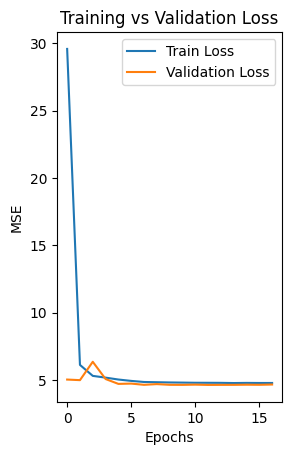

In [272]:
# Loss (MSE)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

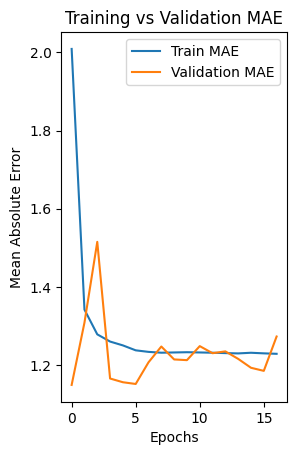

In [273]:
# MAE (Accuracy-like)
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()

In [274]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [275]:
# Add the missing feature columns
df['minutes_form_avg'] = df['minutes'] * df['form_avg']
df["formAvg_minutes_ratio"] = df["form_avg"] / (df["minutes"] + 1)
df['form_avg'] = df['form_avg']

In [276]:
# A5ER HAGA LINEAR REGRESSION EL MAFROOD DAH EL YETSALEM BAS HAN RUN DELWA2TY W YEBAN



In [277]:
feature_set = [
    "position", "assists", "bonus", "clean_sheets",
    "goals_conceded", "goals_scored", "ict_index", "minutes",
    "own_goals", "penalties_missed", "penalties_saved", "saves",
    "total_points", "minutes_points", "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib", "formAvg_minutes_ratio", "ict_per_minute"
]

In [278]:
target = "upcoming_total_points"

In [279]:
X = df[feature_set].copy()
y = df[target]

In [280]:
# One-Hot Encode the categorical "position" column
# drop_first=True avoids multicollinearity by removing one dummy column (e.g., GK)
X = pd.get_dummies(X, columns=['position'], drop_first=True)

# Check the columns created
print("Feature columns after one-hot encoding:\n", X.columns)

Feature columns after one-hot encoding:
 Index(['assists', 'bonus', 'clean_sheets', 'goals_conceded', 'goals_scored',
       'ict_index', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'saves', 'total_points', 'minutes_points',
       'form_avg', 'minutes_form_avg', 'is_home_int', 'goal_contrib',
       'defensive_contrib', 'formAvg_minutes_ratio', 'ict_per_minute',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')


In [281]:
X_train, X_test, y_train, y_testt = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [282]:
scale_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "saves", "form_avg", "minutes_form_avg", "is_home_int",
    "goal_contrib", "defensive_contrib", "formAvg_minutes_ratio", "ict_per_minute"
]

In [283]:
scaler = StandardScaler()

In [284]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])


In [285]:
model = LinearRegression()

In [286]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [287]:
y_predd = model.predict(X_test_scaled)

In [288]:
mae = mean_absolute_error(y_testt, y_predd)
mse = mean_squared_error(y_testt, y_predd)
rmse = np.sqrt(mse)
r2 = r2_score(y_testt, y_predd)

In [289]:
print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.229
Mean Squared Error (MSE): 4.626
Root Mean Squared Error (RMSE): 2.151
R-squared (R²): 0.275


In [290]:
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

In [291]:
print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
                  Feature  Coefficient
6                 minutes     0.823705
13               form_avg     0.746070
5               ict_index     0.255799
20           position_FWD     0.213508
11           total_points     0.188826
22           position_MID     0.078410
21            position_GK     0.062286
10                  saves     0.058459
8        penalties_missed     0.041735
19         ict_per_minute     0.022046
7               own_goals     0.021032
17      defensive_contrib     0.019115
12         minutes_points    -0.001217
0                 assists    -0.008991
9         penalties_saved    -0.017198
18  formAvg_minutes_ratio    -0.027386
16           goal_contrib    -0.029591
3          goals_conceded    -0.034339
4            goals_scored    -0.034471
2            clean_sheets    -0.041745
15            is_home_int    -0.051315
1                   bonus    -0.092102
14       minutes_form_avg    -0.399778


In [292]:
#EXPLAINABILITY
#EXPLAINABILITY
#EXPLAINABILITY
#EXPLAINABILITY

In [293]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5935da1085c51f806a3d39afd390c3b3e22701a1441226a40d52eb6d59548e85
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [294]:
#SHAP and LIME
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

In [295]:
# SHAP EXPLANATIONS
# -----------------
# Convert boolean columns to integers for SHAP compatibility
for col in ['position_FWD', 'position_GK', 'position_MID']:
    if col in X_test_scaled.columns:
        X_test_scaled[col] = X_test_scaled[col].astype(int)
    if col in X_train_scaled.columns:
        X_train_scaled[col] = X_train_scaled[col].astype(int)

explainer = shap.Explainer(model, X_train_scaled, feature_names=X_train_scaled.columns)
shap_values = explainer(X_test_scaled)

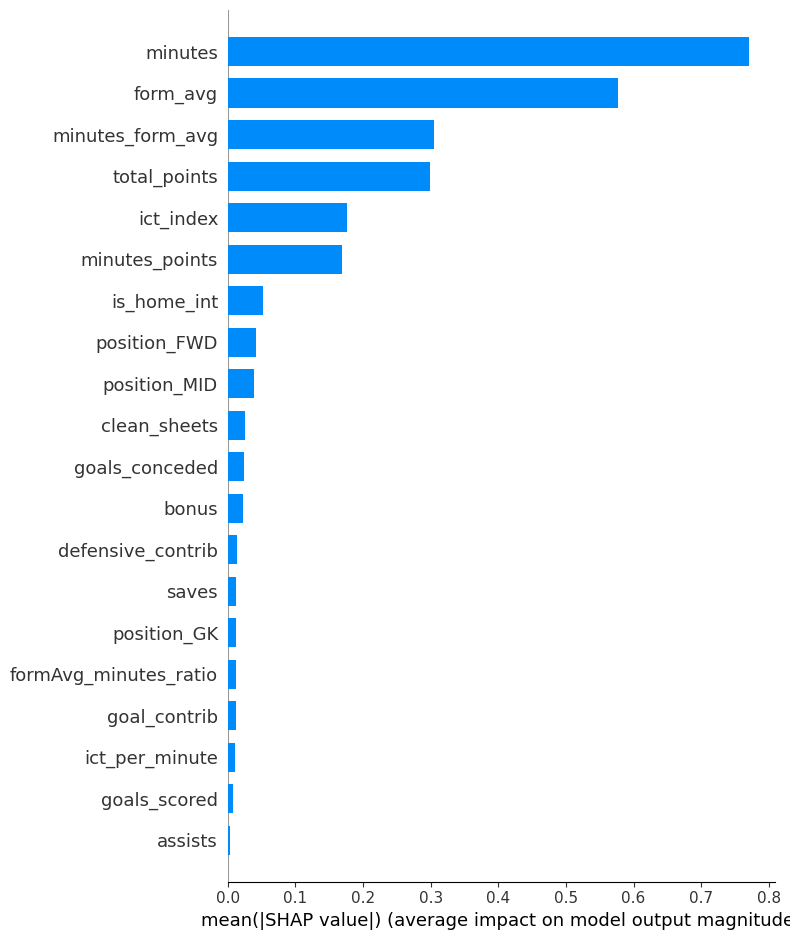

In [296]:
#Global feature importance (mean absolute SHAP values)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

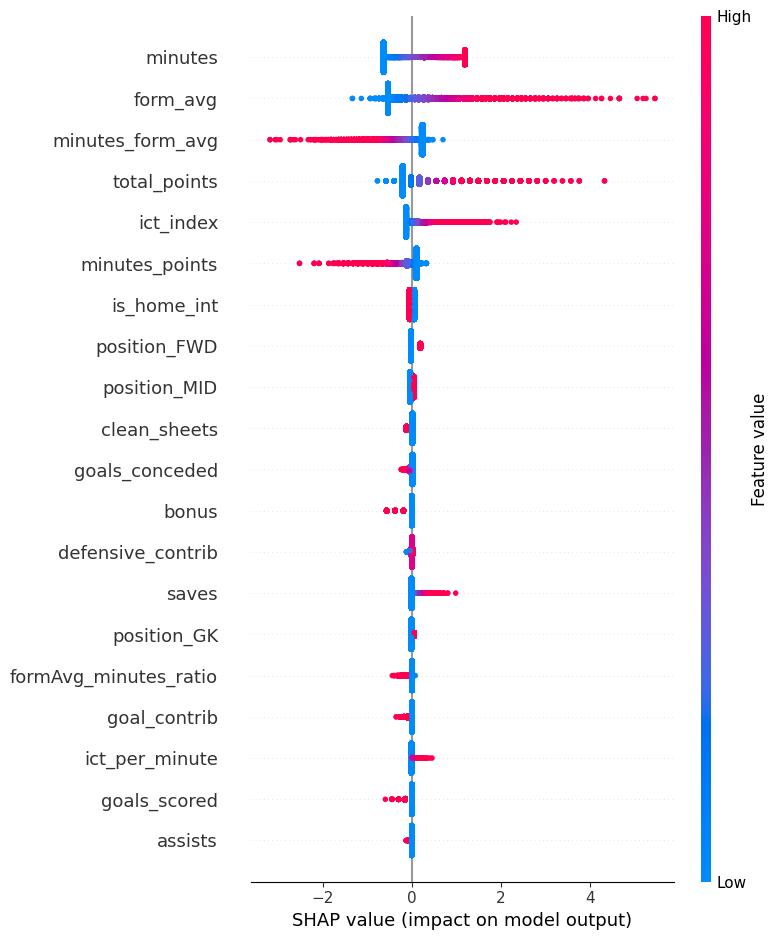

In [297]:
#Detailed summary plot (impact on predictions)
shap.summary_plot(shap_values, X_test_scaled)

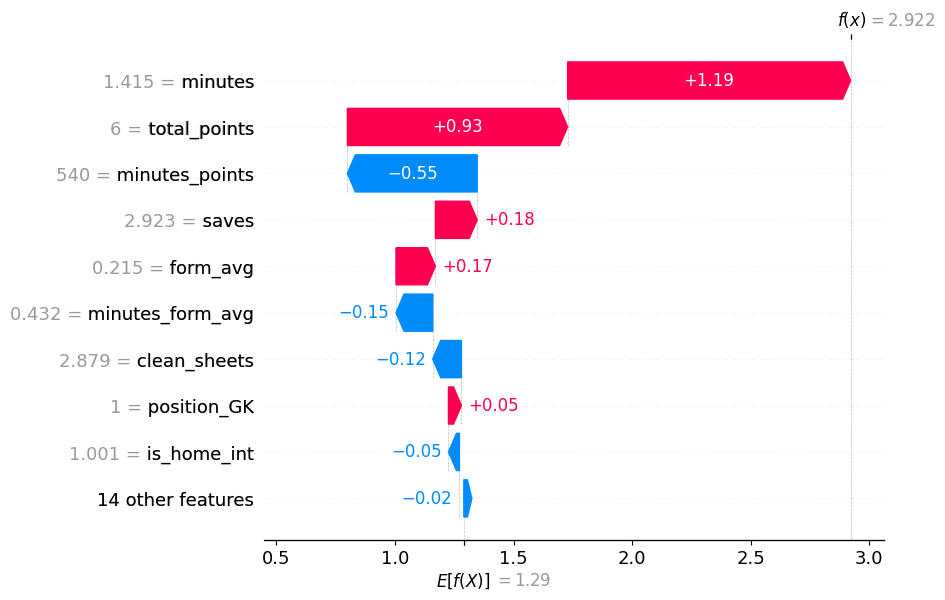

In [298]:
#Explain a single prediction (example: first sample)
sample_index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_index].values,
                                     base_values=shap_values[sample_index].base_values,
                                     feature_names=X_test_scaled.columns,
                                     data=X_test_scaled.iloc[sample_index].values))

In [299]:
# -----------------
# LIME EXPLANATIONS
# -----------------
# Ensure LIME also uses integer types for boolean columns
X_train_scaled_np = np.array(X_train_scaled)
X_test_scaled_np = np.array(X_test_scaled)


lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled_np,
    feature_names=X_train_scaled.columns,
    mode='regression'
)

In [300]:
i = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_scaled_np[i], # Use the numpy array
    predict_fn=model.predict
)

#Show explanation
lime_exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [301]:
#save as HTML file
lime_exp.save_to_file('lime_explanation.html')
print("\nLIME explanation saved as 'lime_explanation.html'")


LIME explanation saved as 'lime_explanation.html'


In [302]:
#INFERENCE FUNCTION
#INFERENCE FUNCTION
#INFERENCE FUNCTION
#INFERENCE FUNCTION

In [303]:
def predict_upcoming_points(raw_input, model, scaler, feature_set, scale_cols, X_reference):
    """
    Predict upcoming_total_points from a raw input dictionary.
    """

    # Convert dict to DataFrame
    df_input = pd.DataFrame([raw_input])

    # Clamp inputs to training range
    for col in scale_cols:
        if col in df_input.columns:
            min_val = X_reference[col].min()
            max_val = X_reference[col].max()
            df_input[col] = np.clip(df_input[col], min_val, max_val)

    # One-hot encode the "position" column (same as training)
    df_input = pd.get_dummies(df_input, columns=['position'], drop_first=True)

    # Align columns with training set (handle missing dummy columns)
    df_input = df_input.reindex(columns=X_reference.columns, fill_value=0)

    # Scale numeric columns
    df_input_scaled = df_input.copy()
    df_input_scaled[scale_cols] = scaler.transform(df_input[scale_cols])

    prediction = model.predict(df_input_scaled)[0]

    return int(round(prediction))


In [304]:
def predict_upcoming_points_noFeatures(raw_input, model, scaler, feature_set, scale_cols, X_reference):
    """
    Predict upcoming_total_points from a raw input dictionary.
    Automatically computes engineered features that the model expects.
    """

    # Convert dict to DataFrame
    df_input = pd.DataFrame([raw_input])

    # -------------------------------
    # ✅ Derive engineered features
    # -------------------------------
    df_input['minutes_form'] = df_input['minutes'] * df_input['form_avg']  # form not provided → use form_avg
    df_input["form_minutes_ratio"] = df_input["form_avg"] / (df_input["minutes"] + 1)

    df_input['minutes_form_avg'] = df_input['minutes'] * df_input['form_avg']
    df_input["formAvg_minutes_ratio"] = df_input["form_avg"] / (df_input["minutes"] + 1)

    df_input["is_home_int"] = df_input.get("is_home_int", df_input.get("was_home", 0)).astype(int)

    df_input["goal_contrib"] = df_input["goals_scored"] + df_input["assists"]
    df_input["defensive_contrib"] = df_input["clean_sheets"] - df_input["goals_conceded"]
    df_input["ict_per_minute"] = df_input["ict_index"] / (df_input["minutes"] + 1)

    df_input['minutes_points'] = df_input['minutes'] * df_input['total_points']
    df_input['minutes_ict'] = df_input['minutes'] * df_input['ict_index']


    # -------------------------------
    # ✅ Clamp values to training range (avoid out-of-distribution)
    # -------------------------------
    for col in scale_cols:
        if col in df_input.columns:
            min_val = X_reference[col].min()
            max_val = X_reference[col].max()
            df_input[col] = np.clip(df_input[col], min_val, max_val)

    # -------------------------------
    # ✅ One-hot encode position, align with training columns
    # -------------------------------
    df_input = pd.get_dummies(df_input, columns=['position'], drop_first=True)

    df_input = df_input.reindex(columns=X_reference.columns, fill_value=0)

    # -------------------------------
    # ✅ Scale numerical columns
    # -------------------------------
    df_input_scaled = df_input.copy()
    df_input_scaled[scale_cols] = scaler.transform(df_input[scale_cols])

    # -------------------------------
    # ✅ Predict and return rounded int
    # -------------------------------
    prediction = model.predict(df_input_scaled)[0]
    return int(round(prediction))


In [305]:
raw_input_def_zero = {
    "position": "DEF",
    "assists": 0,
    "bonus": 0,
    "clean_sheets": 0,
    "goals_conceded": 0,
    "goals_scored": 0,
    "ict_index": 0,
    "minutes": 0,
    "own_goals": 0,
    "penalties_missed": 0,
    "penalties_saved": 0,
    "saves": 0,
    "total_points": 0,
    "minutes_points": 0,
    "form_avg": 0,
    "minutes_form_avg": 0,
    "is_home_int": 0,
    "goal_contrib": 0.0,
    "defensive_contrib": 0.0,
    "formAvg_minutes_ratio": 0.0,
    "ict_per_minute": 0.0
}


predicted_points_def = predict_upcoming_points(
    raw_input=raw_input_def_zero,
    model=model,
    scaler=scaler,
    feature_set=feature_set,
    scale_cols=scale_cols,
    X_reference=X_train_scaled
)

print(f"Predicted upcoming_total_points: {predicted_points_def}")


Predicted upcoming_total_points: 0


In [306]:
raw_input_def = {
    "position": "DEF",
    "assists": 1,
    "bonus": 2,
    "clean_sheets": 1,
    "goals_conceded": 0,
    "goals_scored": 0,
    "ict_index": 25.0,
    "minutes": 90,
    "own_goals": 0,
    "penalties_missed": 0,
    "penalties_saved": 0,
    "saves": 0,
    "total_points": 11,
    "minutes_points": 2,
    "form_avg": 5.5,
    "minutes_form_avg": 5.0,
    "is_home_int": 1,
    "goal_contrib": 0.0,
    "defensive_contrib": 0.7,
    "formAvg_minutes_ratio": 0.055,
    "ict_per_minute": 0.28
}

predicted_points_def = predict_upcoming_points(
    raw_input=raw_input_def,
    model=model,
    scaler=scaler,
    feature_set=feature_set,
    scale_cols=scale_cols,
    X_reference=X_train_scaled
)

print(f"Defender predicted upcoming_total_points: {predicted_points_def:}")


Defender predicted upcoming_total_points: 24


In [307]:
raw_input_def2 = {
    "position": "DEF",
    "assists": 1,
    "bonus": 2,
    "clean_sheets": 1,
    "goals_conceded": 0,
    "goals_scored": 0,
    "ict_index": 25.0,
    "minutes": 90,
    "own_goals": 0,
    "penalties_missed": 0,
    "penalties_saved": 0,
    "saves": 0,
    "total_points": 11,
    "minutes_points": 2,
    "form_avg": 5.5,
    "is_home_int": 1
}

predicted_points_def2 = predict_upcoming_points_noFeatures(
    raw_input=raw_input_def2,
    model=model,
    scaler=scaler,
    feature_set=feature_set,
    scale_cols=scale_cols,
    X_reference=X_train_scaled
)

print(f"Defender predicted upcoming_total_points: {predicted_points_def2:}")


Defender predicted upcoming_total_points: 23


In [308]:
df.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,ict_test,ict_boolean,form,form_avg,upcoming_total_points,minutes_form,form_minutes_ratio,minutes_form_avg,formAvg_minutes_ratio,is_home_int,goal_contrib,defensive_contrib,ict_per_minute,minutes_points,minutes_ict,position_encoded
0,2016-17,Héctor Bellerín,DEF,Arsenal,0,0,9,0,6.8,6,8,4,0,2.8,19.6,2016-08-14T15:00:00Z,90,9,Liverpool,0,0,0,0,1,0,950852,4.0,3.0,2.0,0,0,0,0,65,True,0,1,2.8,True,0.000000,0.000000,9,0.00,0.000000,0.00,0.000000,1,0,-4,0.030769,0,252.0,0
1,2016-17,Héctor Bellerín,DEF,Arsenal,0,3,31,1,28.9,6,13,0,0,6.1,20.8,2016-08-20T16:30:00Z,90,8,Leicester,0,0,0,0,2,0,970078,0.0,0.0,11.0,9,-56304,4952,61256,65,False,0,2,6.1,True,0.000000,0.000000,2,0.00,0.000000,0.00,0.000000,0,0,1,0.067033,810,549.0,0
2,2016-17,Héctor Bellerín,DEF,Arsenal,0,0,16,0,20.4,6,28,1,0,4.5,17.0,2016-08-27T14:00:00Z,90,18,Watford,0,0,0,0,3,0,1003265,3.0,1.0,8.0,2,-14824,23529,38353,65,False,0,3,4.5,True,0.450000,0.450000,2,40.50,0.004945,40.50,0.004945,0,0,-1,0.049451,180,405.0,0
3,2016-17,Héctor Bellerín,DEF,Arsenal,0,0,15,0,5.5,6,31,1,0,2.8,12.4,2016-09-10T14:00:00Z,90,13,Southampton,0,0,0,0,4,0,1012776,1.0,2.0,10.0,2,-22447,29018,51465,65,True,0,4,2.8,True,0.366667,0.366667,2,33.00,0.004029,33.00,0.004029,1,0,-1,0.030769,180,252.0,0
4,2016-17,Héctor Bellerín,DEF,Arsenal,0,0,13,0,22.3,6,43,1,0,3.4,8.0,2016-09-17T14:00:00Z,90,7,Hull,0,0,0,0,5,0,990051,4.0,1.0,4.0,2,-34253,6258,40511,65,False,0,5,3.4,True,0.325000,0.325000,11,29.25,0.003571,29.25,0.003571,0,0,-1,0.037363,180,306.0,0


After installing `lime`, you can run the cell again to generate the SHAP and LIME explanations.